Status: complete

# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark

In [2]:
import collections
import gzip
import itertools
import json
import os
import re
import subprocess
import sys
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from tqdm.auto import tqdm

sys.path.append('../scripts')
import string_distances
import helpers
import plot_features

In [3]:
%watermark
%watermark --conda
%watermark --iversions

Last updated: 2023-11-16T17:47:24.512882-08:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 3.10.0-1160.53.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

conda environment: py3

numpy     : 1.23.5
json      : 2.0.9
scipy     : 1.11.1
pandas    : 2.0.2
matplotlib: 3.7.2
plotly    : 5.15.0
re        : 2.2.1
seaborn   : 0.12.2
sys       : 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]



In [4]:
DIR_PROJECT = '/central/groups/guttman/btyeh/scBarcode'
DIR_DATA = os.path.join(DIR_PROJECT, 'data', '20231107')
DIR_PROC = os.path.join(DIR_PROJECT, 'data_proc', '20231107')
DIR_AUX = os.path.join(DIR_PROJECT, 'data_aux', '20231107')
DIR_RESULTS = os.path.join(DIR_PROJECT, 'results', '20231107')

os.makedirs(DIR_AUX, exist_ok=True)
os.makedirs(DIR_PROC, exist_ok=True)
os.makedirs(DIR_RESULTS, exist_ok=True)

# Constants and Helpers

In [5]:
ROUNDS = ['R1', 'R2', 'R3']

In [6]:
dict_complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C', 'N': 'N'}
def reverse_complement(s, allow_noncanonical=False):
    if allow_noncanonical is False:
        return ''.join(dict_complement[base] for base in reversed(s))
    else:
        return ''.join(dict_complement.get(base, base) for base in reversed(s))

# Data

- [Enhanced Sample Sheet](https://docs.google.com/spreadsheets/d/1r1TVX43_L74VXV9lCeU6EcWGJdWIuF7VKTkeoY_3vlU/)
- [Library sheet](https://docs.google.com/spreadsheets/d/166AyjQdoR9MmSAEsPz3tVJTwkYSH05BL-8XpSagSszs/)
- [Benchling notebook: 2023-11-02 Single Cell Barcode Troubleshooting, v3](https://benchling.com/s/etr-55XImqxPMe9Y2BOH1EEd)
- [splitcode config files as Google Sheet](https://docs.google.com/spreadsheets/d/1rPe2uX68gMgqTqzo6HQYNvgd48PSzPGT-5kxy76MU8g/)

Notes from Tapestation traces
- Samples D3, F3, A4, and A5 generated weaker libraries, especially A5
- Sample B3 had a small shoulder ~50 bp smaller than the expected amplicon size
- Sample F3 yielded an amplicon peak that was ~25 bp larger than the expected amplicon size.

In [7]:
regex_fastq_files = re.compile((
    r'(?P<filename>scBarcode_(?P<sample>[A-Z]\d+)_.*R(?P<read>1|2).fastq.gz)'))

In [8]:
df_data = pd.DataFrame([
    regex_fastq_files.match(file).groupdict() for file in os.listdir(DIR_DATA)
        if file.endswith('.fastq.gz')]) \
    .astype(dict(read=int))

In [9]:
popen_counts = dict()
for sample, group in df_data.groupby('sample'):
    filename = group.loc[group['read'] == 1, 'filename'].item()
    cmd = "unpigz -c {path_fastq_raw} | wc -l | awk '{{print $1 / 4}}'".format(path_fastq_raw=os.path.join(DIR_DATA, filename))
    popen_counts[sample] = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE)

In [10]:
df_data['n_reads'] = int(0)
for sample, popen in popen_counts.items():
    count, err = popen.communicate()
    assert err is None and popen.returncode == 0
    df_data.loc[df_data['sample'] == sample, 'n_reads'] = int(count.decode().strip())

In [11]:
# from the library sheet, linked above
df_data['complexity_tapestation'] = df_data['sample'].map(
    dict(A3=1906685, B3=787943, C3=1628722, D3=503089, F3=59268, A4=273368, A5=26188, C5=2779625))

In [12]:
df_data = df_data.sort_values(['sample', 'read']).reset_index(drop=True)
df_data

filename sample  read  n_reads  complexity_tapestation
0   scBarcode_A3_R1.fastq.gz     A3     1  4155998                 1906685
1   scBarcode_A3_R2.fastq.gz     A3     2  4155998                 1906685
2   scBarcode_A4_R1.fastq.gz     A4     1   554423                  273368
3   scBarcode_A4_R2.fastq.gz     A4     2   554423                  273368
4   scBarcode_A5_R1.fastq.gz     A5     1    25512                   26188
5   scBarcode_A5_R2.fastq.gz     A5     2    25512                   26188
6   scBarcode_B3_R1.fastq.gz     B3     1  1760999                  787943
7   scBarcode_B3_R2.fastq.gz     B3     2  1760999                  787943
8   scBarcode_C3_R1.fastq.gz     C3     1  3392393                 1628722
9   scBarcode_C3_R2.fastq.gz     C3     2  3392393                 1628722
10  scBarcode_C5_R1.fastq.gz     C5     1  6631302                 2779625
11  scBarcode_C5_R2.fastq.gz     C5     2  6631302                 2779625
12  scBarcode_D3_R1.fastq.gz     D3     1  1021974                  503089
13  scBarcode_D3_R2.fastq.gz     D3     2  1021974                  503089
14  scBarcode_F3_R1.fastq.gz     F3     1   102225                   59268
15  scBarcode_F3_R2.fastq.gz     F3     2   102225                   59268

In [13]:
print('Total number of paired reads:', df_data['n_reads'].sum() // 2)

Total number of paired reads: 17644826


Library pooling was nearly perfect with estimated complexity

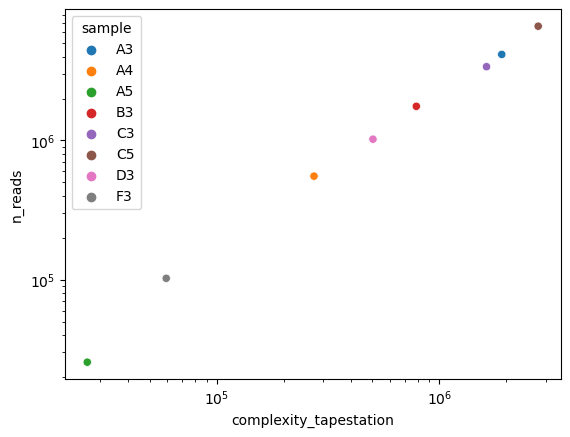

In [14]:
ax = sns.scatterplot(df_data.loc[df_data['read'] == 1], x='complexity_tapestation', y='n_reads', hue='sample')
ax.set_xscale('log')
ax.set_yscale('log')

# FastQC

Expectations
- Read 1: good sequence diversity due to UMIs on the oligo
- Read 2: near total duplication from each sample, since all barcodes from the same nucleus should have the same R2, R3, and NYLigOdd tags

In [15]:
%%bash -s {DIR_DATA} {DIR_PROC}
DIR_DATA="$1"
DIR_PROC="$2"
source ~/.bashrc
conda activate chipdip
DIR_FASTQC_OUT="$DIR_PROC/fastqc"
if [ ! -d "$DIR_FASTQC_OUT" ]; then
    mkdir "$DIR_PROC/fastqc"
    cd "$DIR_DATA"
    fastqc *.fastq.gz -t 20 -q -o "$DIR_FASTQC_OUT"
fi

# Check read structure

Expected read structures (see also Benchling DNA sequence: [Oligo (PC50_12merUMI) + R1-R3 + NYLigOdd PCR Product (2Puni + 2Pbc)](https://benchling.com/s/seq-uec4dPutBQPpgn6aNbXV))

| Component                                 | Length | R1 coordinates | R2 coordinates |
| ----------------------------------------- | ------ | -------------- | -------------- |
| 2Puni adapter, remainder                  | 49     | n/a            | 118:167        |
| 2Puni adapter, continued                  | 10     | n/a            | 108:118        |
| 2Puni adapter, Illumina universal adapter | 11     | n/a            | 97:108         |
| Oligo UMI                                 | 12     | 0:12           | 85:97          |
| LigEven / Even overhang                   | 7      | 12:19          | 78:85          |
| R1 unique sequence                        | 16     | 19:35          | 62:78          |
| LigR1 / R1 overhang                       | 7      | 35:42          | 55:62          |
| R2 unique sequence                        | 16     | 42:58          | 39:55          |
| LigR2 / R2 overhang                       | 7      | 58:65          | 32:39          |
| R3 unique sequence                        | 16     | 65:81          | 16:32          |
| LigR3 / R3 overhang                       | 7      | 81:88          | 9:16           |
| NYLigR3Stg_1 / NYStgBot_1 unique sequence | 9      | 88:97          | 0:9            |
| 2Pbc adapter, start ("AGA")               | 3      | 97:100         | n/a            |
| 2Pbc adapter, continued                   | 63     | n/a            | n/a            |

Note: see the splitcode config file for the subsequences of the 2Puni and 2Pbc adapters that are identified.

## Analysis by group

In [16]:
path_config = os.path.join(DIR_AUX, 'splitcode_config-groups_only_r1.tsv')

# read config file into pandas DataFrame
# - seek to first line after lines starting with '@' or '#'; 
#     pd.read_csv() only supports a single character comment
# - need to open file as binary to enable f.tell() to work
with open(path_config, 'rb') as f:
    pos = f.tell()
    for line in f:
        line = line.decode().strip()
        if line.startswith('#') or line.startswith('@') or line == '':
            pos = f.tell()
            continue
        f.seek(pos)
        break
    df_config = pd.read_csv(f, sep='\t')

Check that tags do not have collisions

In [17]:
regex_distances = re.compile(r'((?P<dist_hamming>\d+):(?P<dist_indel>\d+):)?(?P<dist_total>\d+)')
variant_maps = dict()
for tag_group in df_config['groups'].unique():
    mask_tag_group = df_config['groups'] == tag_group
    seqs = set(df_config.loc[mask_tag_group, 'tags'])
    distances = df_config.loc[mask_tag_group, 'distances'].unique()
    assert len(distances) == 1
    distances = regex_distances.match(distances[0]).groupdict()
    for k in distances:
        if distances[k] is not None:
            distances[k] = int(distances[k])
    variant_maps[tag_group] = string_distances.generate_variant_map(seqs, **distances, verify_unique=True)

In [18]:
all_variants = set()
for tag_group, variants in variant_maps.items():
    assert len(set(variants.keys()) & all_variants) == 0
    all_variants |= set(variants.keys())

### Parse Read 1

In [19]:
%%bash -s {DIR_DATA} {DIR_PROC} {path_config}
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG="$3"

for path_R1 in "$DIR_DATA"/*R1.fastq.gz; do
    SAMPLE="$(echo "$path_R1" | grep -o -E -e '[A-H][0-9]+_R1')"
    path_counts="${DIR_PROC}/tag_group_counts-${SAMPLE}.tsv"

    if [ ! -f "$path_counts" ]; then
        splitcode -c "$PATH_CONFIG" \
            --nFastqs=1 --assign --loc-names --no-outb -t 8 \
            --mapping=/dev/null --output=/dev/stdout \
            "$path_R1" |
        awk '$1 ~ /^@/' |
        grep -o "LX:Z:.*" |
        sed -E -e 's/LX:Z://' -e 's/:0,/:/g' |
        sort |
        uniq -c |
        sed -E -e 's/^ *//' -e 's/ /\t/' |
        sort -n -r > "$path_counts"
    fi
done

Proportion of reads matching expected structure

In [20]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_RESULTS} {path_config}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_RESULTS="$3"
PATH_CONFIG="$4"

for path_R1 in "$DIR_DATA"/*R1.fastq.gz; do
    SAMPLE="$(echo "$path_R1" | grep -o -E -e '[A-H][0-9]+_R1')"
    path_analysis="${DIR_RESULTS}/tag_group_analysis-${SAMPLE}.csv"

    total_reads=$(cat "${DIR_PROC}/tag_group_counts-${SAMPLE}.tsv" |
        cut -f 1 |
        awk '{sum += $1} END {print sum}')

    echo -n "${SAMPLE},expected structure," > "$path_analysis"
    cat "${DIR_PROC}/tag_group_counts-${SAMPLE}.tsv" |
        sed -E -e 's/:[0-9]+-[0-9]+//g' |
        grep -E -e "LigEven,R1Top,LigR1,R2Top,LigR2,R3Top,LigR3,NYLigR3Stg_1" |
        cut -f 1 |
        awk 'BEGIN {ORS=""} {sum += $1} END {print sum}' >> "$path_analysis"
    echo ",$total_reads" >> "$path_analysis"

    echo -n "${SAMPLE},Illumina adapter," >> "$path_analysis"
    cat "${DIR_PROC}/tag_group_counts-${SAMPLE}.tsv" |
        grep -E -e "Illumina" |
        cut -f 1 |
        awk 'BEGIN {ORS=""} {sum += $1} END {print sum}' >> "$path_analysis"
    echo ",$total_reads" >> "$path_analysis"

    echo -n "${SAMPLE},R1 dimer," >> "$path_analysis"
    cat "${DIR_PROC}/tag_group_counts-${SAMPLE}.tsv" |
        grep -E -e "R1Top:[0-9]+-([0-9]+),Lig.{2,4}:\1-([0-9]+),R1Top:\2-([0-9]+),LigR1:\3-[0-9]+" |
        cut -f 1 |
        awk 'BEGIN {ORS=""} {sum += $1} END {print sum}' >> "$path_analysis"
    echo ",$total_reads" >> "$path_analysis"

    echo -n "${SAMPLE},R2 dimer," >> "$path_analysis"
    cat "${DIR_PROC}/tag_group_counts-${SAMPLE}.tsv" |
        grep -E -e "R2Top:[0-9]+-([0-9]+),Lig.{2,4}:\1-([0-9]+),R2Top:\2-([0-9]+),LigR2:\3-[0-9]+" |
        cut -f 1 |
        awk 'BEGIN {ORS=""} {sum += $1} END {print sum}' >> "$path_analysis"
    echo ",$total_reads" >> "$path_analysis"

    # I do not actually expect any reads with R3 dimer to appear in read 1, due to insufficient read length
    echo -n "${SAMPLE},R3 dimer," >> "$path_analysis"
    cat "${DIR_PROC}/tag_group_counts-${SAMPLE}.tsv" |
        grep -E -e "R3Top:[0-9]+-([0-9]+),Lig.{2,4}:\1-([0-9]+),R3Top:\2-([0-9]+),LigR3:\3-[0-9]+" |
        cut -f 1 |
        awk 'BEGIN {ORS=""} {sum += $1} END {print sum}' >> "$path_analysis"
    echo ",$total_reads" >> "$path_analysis"
done

In [22]:
df_group_analysis_r1 = []
for sample in df_data['sample'].unique():
    path_analysis = os.path.join(DIR_RESULTS, f'tag_group_analysis-{sample}_R1.csv')
    df_group_analysis_r1.append(pd.read_csv(path_analysis, header=None, names=['sample', 'structure', 'count', 'total']))
df_group_analysis_r1 = (
    pd.concat(df_group_analysis_r1, axis=0)
    .fillna(0)
    .astype(dict(count=int, total=int))
    .pipe(lambda df: df.assign(proportion=df['count'] / df['total'])))

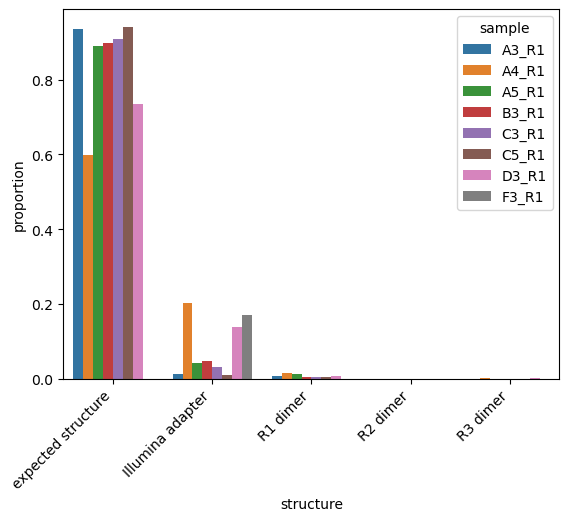

In [25]:
ax = sns.barplot(
    df_group_analysis_r1,
    x='structure',
    y='proportion',
    hue='sample')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.figure.show()

#### Examine samples D3, A4 and F3

In [99]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

for path_counts in "$DIR_PROC"/tag_group_counts-*_R1.tsv; do
    SAMPLE="$(echo "$path_counts" | grep -o -E -e '[A-H][0-9]+_R1')"
    if [[ "$SAMPLE" == "D3_R1" ]] || [[ "$SAMPLE" == "A4_R1" ]] || [[ "$SAMPLE" == "F3_R1" ]]; then
        total_reads=$(cat "${DIR_PROC}/tag_group_counts-${SAMPLE}.tsv" |
            cut -f 1 |
            awk '{sum += $1} END {print sum}')
        echo "$SAMPLE": "$total_reads"
        head "$path_counts"
    fi
done

A4_R1: 554406
313744	LigEven:12-19,R1Top:19-35,LigR1:35-42,R2Top:42-58,LigR2:58-65,R3Top:65-81,LigR3:81-88,NYLigR3Stg_1:88-97
37969	LigEven:12-19,R1Top:19-35,LigR1:35-42,R3Top:42-58,LigR3:58-65,NYLigR3Stg_1:65-74,Illumina:74-85,2Pbc:85-96
27842	LigEven:12-19,R1Top:19-35,LigR1:35-42,R2Bot:42-58,R1:58-65,R1Bot:65-81,Even:81-88
16553	LigEven:12-19,R1Top:19-35,LigR1:35-42,R2Top:42-58,LigR2:58-65,R3Top:65-81,LigR3:81-88
7575	LigEven:12-19,R1Bot:19-35,Even:35-42,R3Top:42-58,LigR3:58-65,NYLigR3Stg_1:65-74,Illumina:74-85,2Pbc:85-96
6710	LigEven:12-19,R1Top:19-35,LigR1:35-42,R1Top:42-58,LigR1:58-65,R2Top:65-81,LigR2:81-88
6542	LigEven:12-19,R1Top:19-35,LigR1:35-42,R3Top:49-65,LigR3:65-72,NYLigR3Stg_1:72-81,Illumina:81-92
5639	LigEven:12-19,R1Top:19-35,NYLigR3Stg_1:38-47,Illumina:47-58,2Pbc:58-69,LigEven:73-80,LigR1:89-96
4310	LigEven:12-19,R1Top:19-35,LigR1:35-42,R2Top:42-58,LigR2:58-65,R3Top:65-81,LigR3:81-88,NYLigR3Stg_1:88-96
3627	LigEven:12-19,R1Top:19-35,LigR1:35-42,R2Top:42-57,LigR2:57-64

Sample A4
- 2nd most common structure (~6.8% reads): R3 ligates R1
- 3rd most common structure (~5% reads): Oligo + R1 + R2' + R1' + Oligo', where the ' indicates reverse complement
- 5th most common structure (~3% reads): ??

Sample D3
- 2nd most common structure (~6.2% reads): R3 ligates R1
- 5th most common structure (~1% reads): NYLigR3 ligates R1 via a 3 bp overhang
- Several other common structures with expected Oligo + R1-R3, but NYLigR3 is not detected.

Sample F3
- LigEven is positioned 5-6 bp away from its expected position
- Most common structures only have detectable overhang sequences, but no detectable unique tag sequences.

### Parse Read 2

In [26]:
path_config = os.path.join(DIR_AUX, 'splitcode_config-groups_only.tsv')

In [29]:
%%bash -s {DIR_DATA} {DIR_PROC} {path_config}
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG="$3"

for path_R2 in "$DIR_DATA"/*R2.fastq.gz; do
    SAMPLE="$(echo "$path_R2" | grep -o -E -e '[A-H][0-9]+_R2')"
    path_counts="${DIR_PROC}/tag_group_counts-${SAMPLE}.tsv"

    if [ ! -f "$path_counts" ]; then
        splitcode -c "$PATH_CONFIG" \
            --nFastqs=1 --assign --loc-names --no-outb -t 8 \
            --mapping=/dev/null --output=/dev/stdout \
            "$path_R2" |
        awk '$1 ~ /^@/' |
        grep -o "LX:Z:.*" |
        sed -E -e 's/LX:Z://' -e 's/:0,/:/g' |
        sort |
        uniq -c |
        sed -E -e 's/^ *//' -e 's/ /\t/' |
        sort -n -r > "$path_counts"
    fi
done

* Using a list of 157 tags (vector size: 157; map size: 106,732; num elements in map: 107,886)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20231107/scBarcode_A3_R2.fastq.gz
* processing the reads ...
done 
* processed 4,155,998 reads, 4,155,948 reads were assigned
* Using a list of 157 tags (vector size: 157; map size: 106,732; num elements in map: 107,886)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20231107/scBarcode_A4_R2.fastq.gz
* processing the reads ...
done 
* processed 554,423 reads, 554,418 reads were assigned
* Using a list of 157 tags (vector size: 157; map size: 106,732; num elements in map: 107,886)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20231107/scBarcode_A5_R2.fastq.gz
* processing the reads ...
done 
* processed 25,512 reads, 25,512 reads were assigned
* Using a list of 157 tags (vector size: 157; map size: 106,732; num elements in map: 107,886)
* will process sample 1: /central/groups/g

Proportion of reads matching expected structure

In [41]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_RESULTS} {path_config}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_RESULTS="$3"
PATH_CONFIG="$4"

for path_R2 in "$DIR_DATA"/*R2.fastq.gz; do
    SAMPLE="$(echo "$path_R2" | grep -o -E -e '[A-H][0-9]+_R2')"
    path_counts="${DIR_PROC}/tag_group_counts-${SAMPLE}.tsv"
    path_analysis="${DIR_RESULTS}/tag_group_analysis-${SAMPLE}.csv"

    total_reads=$(cat "$path_counts" | cut -f 1 | awk '{sum += $1} END {print sum}')

    echo -n "${SAMPLE},expected structure," > "$path_analysis"
    cat "$path_counts" |
        sed -E -e 's/:[0-9]+-[0-9]+//g' |
        grep -E -e "NYStgBot_1,R3,R3Bot,R2,R2Bot,R1,R1Bot,Even,([^,]+,){1,2}2Puni" |
        cut -f 1 |
        awk 'BEGIN {ORS=""} {sum += $1} END {print sum}' >> "$path_analysis"
    echo ",$total_reads" >> "$path_analysis"

    echo -n "${SAMPLE},R1 dimer," >> "$path_analysis"
    cat "$path_counts" |
        grep -E -e "R1Bot:[0-9]+-([0-9]+),R1:\1-([0-9]+),R1Bot:\2-" |
        cut -f 1 |
        awk 'BEGIN {ORS=""} {sum += $1} END {print sum}' >> "$path_analysis"
    echo ",$total_reads" >> "$path_analysis"

    echo -n "${SAMPLE},R2 dimer," >> "$path_analysis"
    cat "$path_counts" |
        grep -E -e "R2Bot:[0-9]+-([0-9]+),R2:\1-([0-9]+),R2Bot:\2-" |
        cut -f 1 |
        awk 'BEGIN {ORS=""} {sum += $1} END {print sum}' >> "$path_analysis"
    echo ",$total_reads" >> "$path_analysis"

    # I do not actually expect any reads with R3 dimer to appear in read 1, due to insufficient read length
    echo -n "${SAMPLE},R3 dimer," >> "$path_analysis"
    cat "$path_counts" |
        grep -E -e "R3Bot:[0-9]+-([0-9]+),R3:\1-([0-9]+),R3Bot:\2-" |
        cut -f 1 |
        awk 'BEGIN {ORS=""} {sum += $1} END {print sum}' >> "$path_analysis"
    echo ",$total_reads" >> "$path_analysis"
done

In [42]:
df_group_analysis_r2 = []
for sample in df_data['sample'].unique():
    path_analysis = os.path.join(DIR_RESULTS, f'tag_group_analysis-{sample}_R2.csv')
    df_group_analysis_r2.append(pd.read_csv(path_analysis, header=None, names=['sample', 'structure', 'count', 'total']))
df_group_analysis_r2 = (
    pd.concat(df_group_analysis_r2, axis=0)
    .fillna(0)
    .astype(dict(count=int, total=int))
    .pipe(lambda df: df.assign(proportion=df['count'] / df['total'])))

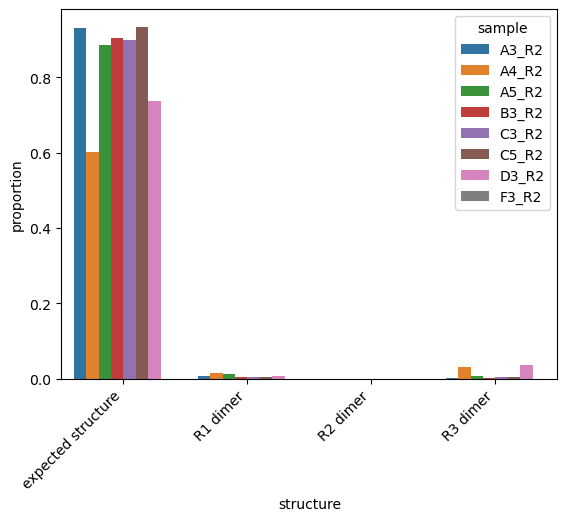

In [43]:
ax = sns.barplot(
    df_group_analysis_r2,
    x='structure',
    y='proportion',
    hue='sample')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.figure.show()

#### Examine samples D3, A4, and F3

In [44]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

for path_counts in "$DIR_PROC"/tag_group_counts-*_R2.tsv; do
    SAMPLE="$(echo "$path_counts" | grep -o -E -e '[A-H][0-9]+_R2')"
    if [[ "$SAMPLE" == "D3_R2" ]] || [[ "$SAMPLE" == "A4_R2" ]] || [[ "$SAMPLE" == "F3_R2" ]]; then
        total_reads=$(cat "${DIR_PROC}/tag_group_counts-${SAMPLE}.tsv" |
            cut -f 1 |
            awk '{sum += $1} END {print sum}')
        echo "$SAMPLE": "$total_reads"
        head "$path_counts"
    fi
done

A4_R2: 554418
265677	NYStgBot_1:0-9,R3:9-16,R3Bot:16-32,R2:32-39,R2Bot:39-55,R1:55-62,R1Bot:62-78,Even:78-85,Illumina:97-108,2Puni:108-118
25855	NYStgBot_1:0-9,R3:9-16,R3Bot:16-32,R1:32-39,R1Bot:39-55,Even:55-62,Illumina:74-85,2Puni:85-95,R3:184-191
19548	NYStgBot_1:0-9,R3:9-16,R3Bot:16-32,LigEven:32-39,R1Top:39-55,LigR1:55-62,R2Top:62-78,R1:78-85,R1Bot:85-101,Even:101-108,Illumina:120-131,2Puni:131-141
10071	NYStgBot_1:0-9,R3:9-16,R3Bot:16-32,R3:32-39,R3Bot:39-55,R2:55-62,R2Bot:62-78,R1:78-85,R1Bot:85-101,Even:101-108,Illumina:120-131,2Puni:131-141
6734	NYStgBot_1:0-9,R3:9-16,R3Bot:16-32,R2:32-39,R2Bot:39-55,R1:55-62,R1Bot:62-78,Even:78-85,Illumina:97-108,2Puni:108-118,LigR2:137-144
5492	NYStgBot_1:0-9,R3:9-16,R3Bot:16-32,LigEven:32-39,R1Top:39-55,Even:55-62,Illumina:74-85,2Puni:85-95,R3:184-191
5355	NYStgBot_1:0-9,R3:9-16,R3Bot:16-32,R2:32-39,R2Bot:39-55,R1:55-62,R1Bot:62-78,R1:78-85,R1Bot:85-101,Even:101-108,Illumina:120-131,2Puni:131-141
4521	NYStgBot_1:0-9,R3:9-16,R3Bot:16-32,R1:3

Sample A4
- (As in read 1) 2nd most common structure (~6.8% reads): R3 ligates R1
- (As in read 1) 3rd most common structure (~5% reads): Oligo + R1 + R2' + R1' + R3 + NY, where the ' indicates reverse complement
- 4th most common: R3 dimer

Sample D3
- (As in read 1) 2nd most common structure (~6.2% reads): R3 ligates R1
- 3rd most common structure: R3 dimer

##### Sample F3: Odd / Even Tag Contamination

Sample F3 has repeating odd / even overhangs 17 bp apart, suggesting contamination by odd / even tags.

However, it is unclear how the oligo-equivalent component of these reads are structured: `Even:106-113,Illumina:130-141`
- Usually, the 12 bp UMI separates the Even overhang from the Illumina adapter sequence. Here, there is a 17 bp separation.

In [69]:
path_config = os.path.join(DIR_AUX, 'splitcode_config-groups_only_odd_even.tsv')

# read config file into pandas DataFrame
# - seek to first line after lines starting with '@' or '#'; 
#     pd.read_csv() only supports a single character comment
# - need to open file as binary to enable f.tell() to work
with open(path_config, 'rb') as f:
    pos = f.tell()
    for line in f:
        line = line.decode().strip()
        if line.startswith('#') or line.startswith('@') or line == '':
            pos = f.tell()
            continue
        f.seek(pos)
        break
    df_config = pd.read_csv(f, sep='\t')

Check that tags do not have collisions

In [70]:
regex_distances = re.compile(r'((?P<dist_hamming>\d+):(?P<dist_indel>\d+):)?(?P<dist_total>\d+)')
variant_maps = dict()
for tag_group in df_config['groups'].unique():
    mask_tag_group = df_config['groups'] == tag_group
    seqs = set(df_config.loc[mask_tag_group, 'tags'])
    distances = df_config.loc[mask_tag_group, 'distances'].unique()
    assert len(distances) == 1
    distances = regex_distances.match(distances[0]).groupdict()
    for k in distances:
        if distances[k] is not None:
            distances[k] = int(distances[k])
    variant_maps[tag_group] = string_distances.generate_variant_map(seqs, **distances, verify_unique=True)

In [71]:
all_variants = set()
for tag_group, variants in variant_maps.items():
    assert len(set(variants.keys()) & all_variants) == 0
    all_variants |= set(variants.keys())

In [73]:
%%bash -s {DIR_DATA} {DIR_PROC} {path_config}
DIR_DATA="$1"
DIR_PROC="$2"
PATH_CONFIG="$3"

path_r2="$DIR_DATA/scBarcode_F3_R2.fastq.gz"
SAMPLE="$(echo "$path_r2" | grep -o -E -e '[A-H][0-9]+_R2')"
path_counts="${DIR_PROC}/tag_group_counts-odd_even-${SAMPLE}.tsv"

if [ ! -f "$path_counts" ]; then
    splitcode -c "$PATH_CONFIG" \
        --nFastqs=1 --assign --loc-names --no-outb -t 8 \
        --mapping=/dev/null --output=/dev/stdout \
        "$path_r2" |
    awk '$1 ~ /^@/' |
    grep -o "LX:Z:.*" |
    sed -E -e 's/LX:Z://' -e 's/:0,/:/g' |
    sort |
    uniq -c |
    sed -E -e 's/^ *//' -e 's/ /\t/' |
    sort -n -r > "$path_counts"
fi

* Using a list of 541 tags (vector size: 541; map size: 425,696; num elements in map: 429,793)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20231107/scBarcode_F3_R2.fastq.gz
* processing the reads ...
done 
* processed 102,225 reads, 102,223 reads were assigned


In [74]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"

path_counts="${DIR_PROC}/tag_group_counts-odd_even-F3_R2.tsv"
head "$path_counts"

10438	Even:10-17,EvenBot:17-34,R3:34-41,OddBot:41-58,Even:58-65,EvenBot:65-82,R3:82-89,OddBot:89-106,Even:106-113,Illumina:130-141,2Puni:141-151
7706	Even:9-16,EvenBot:16-33,R3:33-40,OddBot:40-57,Even:57-64,EvenBot:64-81,R3:81-88,OddBot:88-105,Even:105-112,Illumina:129-140,2Puni:140-150
6100	Even:10-17,EvenBot:17-34,R3:34-41,OddBot:41-58,Even:58-65,EvenBot:65-82,R3:82-89,OddBot:89-106,Even:106-113,Illumina:131-142,2Puni:142-152
5172	Even:10-17,EvenBot:17-34,R3:34-41,OddBot:41-58,Even:58-65,EvenBot:65-82,R3:82-89,OddBot:89-106,Even:106-113,LigR3:125-132,Illumina:132-142,2Puni:142-152
4949	Even:12-19,EvenBot:19-36,R3:36-43,OddBot:43-60,Even:60-67,EvenBot:67-84,R3:84-91,OddBot:91-108,Even:108-115,Illumina:132-143,2Puni:143-153
4431	Even:9-16,EvenBot:16-33,R3:33-40,OddBot:40-57,Even:57-64,EvenBot:64-81,R3:81-88,OddBot:88-105,Even:105-112,Illumina:130-141,2Puni:141-151
3540	Even:9-16,EvenBot:16-33,R3:33-40,OddBot:40-57,Even:57-64,EvenBot:64-81,R3:81-88,OddBot:88-105,Even:105-112,LigR3:124-1

# Count barcodes

## Splitcode

1. Add barcode and UMI to read name

   `@read::[NYStgBot_1][R3][R3Bot][R2][R2Bot][R1][R1Bot][Even][2Puni] RX:Z:<UMI>`

2. Calculate barcode counts

### Config file

Only use read 2 (200 bp)

In [75]:
path_config = os.path.join(DIR_AUX, 'splitcode_config-r2_expected_structure.tsv')

# read config file into pandas DataFrame
# - seek to first line after lines starting with '@' or '#'; 
#     pd.read_csv() only supports a single character comment
# - need to open file as binary to enable f.tell() to work
with open(path_config, 'rb') as f:
    pos = f.tell()
    for line in f:
        line = line.decode().strip()
        if line.startswith('#') or line.startswith('@') or line == '':
            pos = f.tell()
            continue
        f.seek(pos)
        break
    df_config = pd.read_csv(f, sep='\t')

Check that tags do not have collisions

In [76]:
regex_distances = re.compile(r'((?P<dist_hamming>\d+):(?P<dist_indel>\d+):)?(?P<dist_total>\d+)')
variant_maps = dict()
for tag_group in df_config['groups'].unique():
    mask_tag_group = df_config['groups'] == tag_group
    seqs = set(df_config.loc[mask_tag_group, 'tags'])
    distances = df_config.loc[mask_tag_group, 'distances'].unique()
    assert len(distances) == 1
    distances = regex_distances.match(distances[0]).groupdict()
    for k in distances:
        if distances[k] is not None:
            distances[k] = int(distances[k])
    variant_maps[tag_group] = string_distances.generate_variant_map(seqs, **distances, verify_unique=True)

In [77]:
all_variants = set()
for tag_group, variants in variant_maps.items():
    assert len(set(variants.keys()) & all_variants) == 0
    all_variants |= set(variants.keys())

### Run splitcode

In [21]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_AUX} {path_config}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_AUX="$3"
PATH_CONFIG="$4"

source ~/.bashrc

for path_R2 in "$DIR_DATA"/*R2.fastq.gz; do
    SAMPLE="$(echo "$path_R2" | grep -o -E -e '[A-H][0-9]+')"
    PATH_MAPPING="${DIR_PROC}/mapping-${SAMPLE}.tsv"
    PATH_SUMMARY="${DIR_PROC}/summary-${SAMPLE}.json"
    PATH_OUTPUT="${DIR_PROC}/read_barcodes-${SAMPLE}.txt.gz"

    if [ ! -f "$PATH_OUTPUT" ]; then
        splitcode -c "$PATH_CONFIG" \
            --nFastqs=1 --assign --mod-names --x-names --no-x-out --no-outb --out-fasta -t 8 \
            --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" --output=/dev/stdout \
            "$path_R2" |
        awk '$1 ~ /^>/' |
        pigz -p 8 > "$PATH_OUTPUT"
    fi
done

* Using a list of 78 tags (vector size: 78; map size: 2,005,965; num elements in map: 2,071,566)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20231107/scBarcode_A3_R2.fastq.gz
* processing the reads ...
done 
* processed 4,155,998 reads, 3,946,905 reads were assigned
* Using a list of 78 tags (vector size: 78; map size: 2,005,965; num elements in map: 2,071,566)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20231107/scBarcode_A4_R2.fastq.gz
* processing the reads ...
done 
* processed 554,423 reads, 338,889 reads were assigned
* Using a list of 78 tags (vector size: 78; map size: 2,005,965; num elements in map: 2,071,566)
* will process sample 1: /central/groups/guttman/btyeh/scBarcode/data/20231107/scBarcode_A5_R2.fastq.gz
* processing the reads ...
done 
* processed 25,512 reads, 23,175 reads were assigned
* Using a list of 78 tags (vector size: 78; map size: 2,005,965; num elements in map: 2,071,566)
* will process sample 1: /central/

Proportion of reads from each sample that were properly barcoded (considered "assigned" by splitcode)

In [16]:
df_data['n_assigned'] = 0
for sample in df_data['sample'].unique():
    mask_sample = df_data['sample'] == sample
    n_reads = df_data.loc[mask_sample, 'n_reads'].iloc[0]
    path_summary = os.path.join(DIR_PROC, f'summary-{sample}.json')
    with open(path_summary, 'rt') as f:
        summary = json.load(f)
    assert summary['n_processed'] == n_reads
    df_data.loc[mask_sample, 'n_assigned'] = summary['n_assigned']

In [17]:
(df_data[['sample', 'n_reads', 'n_assigned']].drop_duplicates()
    .set_index('sample')
    .pipe(lambda df: df.assign(prop_assigned=df['n_assigned'] / df['n_reads']))['prop_assigned'])

sample
A3    0.949689
A4    0.611246
A5    0.908396
B3    0.915637
C3    0.918311
C5    0.949913
D3    0.745703
F3    0.000000
Name: prop_assigned, dtype: float64

## Parse identified barcodes to counts

Structure of `sample_barcode_counts` dictionary
- key: sample
- value: `sample_data`
  - key: barcode
  - value: `barcode_data`
    - key: UMI
    - value: count

Note that a handful of UMIs contain bases recorded as `N`.

In [18]:
%%bash -s {DIR_PROC}
DIR_PROC="$1"
zcat "$DIR_PROC/read_barcodes-A3.txt.gz" | grep -E -e 'RX:Z:[ATCG]*N[ATCG]*'

>AV233703:20231107:2142988255:1:10102:5461:3425::[NYStgBot_1][R3][R3Bot_3][R2][R2Bot_18][R1][R1Bot_10][Even][2Puni] RX:Z:AAGTTNCCATGC
>AV233703:20231107:2142988255:1:10602:5461:2791::[NYStgBot_1][R3][R3Bot_13][R2][R2Bot_4][R1][R1Bot_10][Even][2Puni] RX:Z:CTAACNTCGTTC
>AV233703:20231107:2142988255:1:20703:5461:0394::[NYStgBot_1][R3][R3Bot_2][R2][R2Bot_15][R1][R1Bot_10][Even][2Puni] RX:Z:GTGCCNCGTTAC
>AV233703:20231107:2142988255:1:11401:5461:0805::[NYStgBot_1][R3][R3Bot_2][R2][R2Bot_5][R1][R1Bot_10][Even][2Puni] RX:Z:TTATTNTTATTA
>AV233703:20231107:2142988255:1:21501:4198:3531::[NYStgBot_1][R3][R3Bot_2][R2][R2Bot_2][R1][R1Bot_11][Even][2Puni] RX:Z:CGTGCCNATAGT
>AV233703:20231107:2142988255:1:11502:5460:3157::[NYStgBot_1][R3][R3Bot_2][R2][R2Bot_17][R1][R1Bot_10][Even][2Puni] RX:Z:ACCGTNCTGGGC
>AV233703:20231107:2142988255:1:21702:5460:2634::[NYStgBot_1][R3][R3Bot_2][R2][R2Bot_8][R1][R1Bot_10][Even][2Puni] RX:Z:TACGTNGCGAGT
>AV233703:20231107:2142988255:1:11801:5461:0175::[NYStgBot_1][R3]

In [19]:
regex_oligo_cell_barcode = re.compile((
    r'\[NYStgBot_1\]'
    r'\[R3\]'
    r'(?P<barcode>'
    r'\[R3Bot_(?P<R3>\d+)\]'
    r'\[R2\]'
    r'\[R2Bot_(?P<R2>\d+)\]'
    r'\[R1\]'
    r'\[R1Bot_(?P<R1>\d+)\])'
))
regex_umi = re.compile(r'RX:Z:([ATCGN]+)')

In [20]:
sample_barcode_counts = dict()
sample_barcode_inconsistencies = []
path_barcode_inconsistencies = os.path.join(DIR_PROC, 'barcode_inconsistencies.csv')
for sample in df_data['sample'].unique():
    path_read_barcodes = os.path.join(DIR_PROC, f'read_barcodes-{sample}.txt.gz')
    path_barcode_counts = os.path.join(DIR_PROC, f'barcode_counts-{sample}.json.gz')
    if not os.path.exists(path_barcode_counts):
        sample_data = dict()
        no_match = 0
        no_umi = 0
        bad_umi = 0
        with gzip.open(path_read_barcodes, 'rt') as f:
            for name in f:
                name = name.strip()
                match = regex_oligo_cell_barcode.search(name)
                if match:
                    tags = match.groupdict()
                    barcode = tags['barcode']
                    umi = regex_umi.search(name)
                    if umi is None:
                        no_umi += 1
                        continue
                    else:
                        umi = umi.group(1)
                        if 'N' in umi:
                            bad_umi += 1
                            continue
                    if barcode not in sample_data:
                        sample_data[barcode] = collections.defaultdict(int)
                    sample_data[barcode][umi] += 1
                else:
                    no_match += 1
        with gzip.open(path_barcode_counts, 'wt') as f:
            json.dump(sample_data, f)
        sample_barcode_inconsistencies.append({
            'sample': sample,
            'no_match': no_match,
            'no_umi': no_umi,
            'bad_umi': bad_umi
        })
    else:
        print(f'{sample}: loading existing counts')
        with gzip.open(path_barcode_counts, 'rt') as f:
            sample_data = json.load(f)
    sample_barcode_counts[sample] = sample_data

A3: loading existing counts
A4: loading existing counts
A5: loading existing counts
B3: loading existing counts
C3: loading existing counts
C5: loading existing counts
D3: loading existing counts
F3: loading existing counts


In [21]:
if len(sample_barcode_inconsistencies) > 0:
    sample_barcode_inconsistencies = pd.DataFrame(sample_barcode_inconsistencies)
    sample_barcode_inconsistencies.to_csv(path_barcode_inconsistencies)
else:
    sample_barcode_inconsistencies = pd.read_csv(path_barcode_inconsistencies)

In [22]:
print('no_match = reads with missing tags')
print('no_umi = reads lacking 12 bp UMI')
print('bad_umi = reads whose UMIs contain \'N\'')
display(sample_barcode_inconsistencies)

no_match = reads with missing tags
no_umi = reads lacking 12 bp UMI
bad_umi = reads whose UMIs contain 'N'


Unnamed: 0.1  Unnamed: 0 sample  no_match  no_umi  bad_umi
0             0           0     A3     60564   49043        8
1             1           1     A4      8441    4189        2
2             2           2     A5       414     283        0
3             3           3     B3     22874   15803        2
4             4           4     C3     40830   33190       10
5             5           5     C5     97255   62563       21
6             6           6     D3     15773    8451        3
7             7           7     F3         0       0        0

In [23]:
print(
    'Total number of read pairs with correct barcode structure:',
    sum(
        sum(barcode_data.values())
        for sample_data in sample_barcode_counts.values()
        for barcode_data in sample_data.values()))

Total number of read pairs with correct barcode structure: 15678206


### Parse barcode counts to DataFrames

- `df_umi_counts`: closest representation of raw data; counts per [[barcode + UMI]]
  - format: wide
  - `id_vars`: `sample`, `R1`, `R2`, `R3`, `umi`
  - `value_vars`: `count`
- `df_barcode_counts`: counts (both undeduplicated and deduplicated by UMI) per [[barcode]]
  - format: wide
  - `id_vars`: `sample`, `R1`, `R2`, `R3`
  - `value_vars`: `count`, `count_dedup`
- `df_tag_counts`: counts per [[tag]]
  - format: long
  - `id_vars`: `sample`, `round`, `tag`, `deduplication`
  - `value_vars`: `count`

In [24]:
df_umi_counts = []
for sample, sample_data in sample_barcode_counts.items():
    for barcode, barcode_data in sample_data.items():
        for umi, count in barcode_data.items():
            df_umi_counts.append([sample, barcode, umi, count])
df_umi_counts = pd.DataFrame(df_umi_counts, columns=['sample', 'barcode', 'umi', 'count']) \
    .astype(dict(sample='category'))

In [25]:
df_umi_counts = pd.concat(
    (
        df_umi_counts.drop(columns='barcode'),
        df_umi_counts["barcode"].str.extract((
            r'\[R3Bot_(?P<R3>\d+)\]'
            r'\[R2\]'
            r'\[R2Bot_(?P<R2>\d+)\]'
            r'\[R1\]'
            r'\[R1Bot_(?P<R1>\d+)\]'
        ))),
    axis=1
).astype(dict(R1=np.uint8, R2=np.uint8, R3=np.uint8))

In [26]:
df_barcode_counts = (
    df_umi_counts.groupby(["sample"] + ROUNDS, observed=True)["count"]
    .agg(["count", "sum"])
    .reset_index()
    .rename(columns={"count": "count_dedup", "sum": "count"})
)

In [27]:
df_tag_counts = (
    df_barcode_counts
    .melt(
        id_vars=["sample", "count", "count_dedup"],
        value_vars=ROUNDS,
        var_name="round",
        value_name="tag")
    .groupby(["sample", "round", "tag"], observed=True)
    .agg({"count": "sum", "count_dedup": "sum"})
    .reset_index()
    .rename(columns={"count": "no", "count_dedup": "yes"})
    .melt(
        id_vars=["sample", "round", "tag"],
        value_vars=["yes", "no"],
        var_name="deduplication",
        value_name="count")
    .astype(dict(round="category", deduplication="category")))

### Check for tags that are missing from this dataset

The R1, R2, or R3 have no missing tags, as expected.

Oddly, NYLigOdd tags 6, 11, 12, and 24 are rare/missing.

In [28]:
expected_tags = {
    'R1': set(range(1, 25)),
    'R2': set(range(1, 25)),
    'R3': set(range(1, 25))}

In [29]:
df_missing_tags = []
assert (df_tag_counts['count'] > 0).all()
for sample, group in df_tag_counts.groupby('sample'):
    for r in ROUNDS:
        missing_tags = expected_tags[r] - set(group.loc[group['round'] == r, 'tag'])
        rare_tags = set(group.loc[
            (group['round'] == r) &
            (group['deduplication'] == 'yes') &
            (group['count'] > 0) &
            (group['count'] < 50),
            'tag'])
        assert len(missing_tags & rare_tags) == 0
        df_missing_tags.append(dict(
            sample=sample,
            round=r,
            missing_tags=missing_tags,
            rare_tags=rare_tags))
df_missing_tags = pd.DataFrame(df_missing_tags).sort_values(['round', 'sample'])
df_missing_tags

sample round missing_tags               rare_tags
0      A3    R1           {}                      {}
3      A4    R1           {}                      {}
6      A5    R1           {}                      {}
9      B3    R1           {}                      {}
12     C3    R1           {}                      {}
15     C5    R1           {}                      {}
18     D3    R1           {}                      {}
1      A3    R2           {}                      {}
4      A4    R2           {}                      {}
7      A5    R2           {}                      {}
10     B3    R2           {}                      {}
13     C3    R2           {}                      {}
16     C5    R2           {}                      {}
19     D3    R2           {}                      {}
2      A3    R3           {}                      {}
5      A4    R3           {}                      {}
8      A5    R3           {}  {5, 7, 11, 18, 19, 24}
11     B3    R3           {}                      {}
14     C3    R3           {}                    {24}
17     C5    R3           {}                      {}
20     D3    R3           {}                     {2}

# Sequencing Depth and Duplicates

## UMI distribution

In [30]:
with pd.option_context('display.float_format', '{:,g}'.format):
    display(df_umi_counts['count'].describe())

count   1.19642e+07
mean        1.31043
std        0.613069
min               1
25%               1
50%               1
75%               1
max              11
Name: count, dtype: float64

Distribution of UMIs per sample

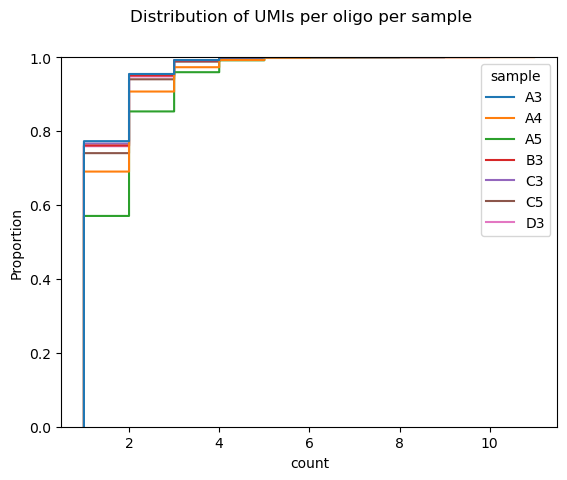

In [31]:
ax = sns.ecdfplot(
    df_umi_counts,
    x='count',
    hue='sample')
ax.figure.suptitle('Distribution of UMIs per oligo per sample')
ax.figure.show()

### Estimate library complexity from sequencing/UMI duplicates

Note: The current method of library complexity estimation assumes that the number of available UMIs far exceeds the number of unique molecules, and therefore underestimates the true library complexity. A better model would account for the possibility of real UMI collisions, and as a consequence of PCR duplicates/sequencing.

In [32]:
def estimate_library_complexity(count_total, count_dedup, max_err=1e-3):
    '''
    See https://github.com/bentyeh/resources/blob/main/bioinformatics/models_genomics.md
    '''
    res = scipy.optimize.minimize_scalar(
      fun=lambda M: (M * (1 - np.exp(-count_total/M)) - count_dedup)**2,
      bracket=(count_dedup, count_total*2)
    )
    assert res.fun < max_err
    return res.x

In [33]:
umi_complexity = 4**12
print('Maximum UMI complexity:', umi_complexity)

Maximum UMI complexity: 16777216


#### Option 1: From all barcodes per sample

In [34]:
complexity_umi_all = df_barcode_counts.groupby('sample')[['count', 'count_dedup']].sum().apply(
    lambda s: estimate_library_complexity(s['count'], s['count_dedup']),
    axis=1)

#### Option 2: From predominant barcode per sample

In [35]:
top_barcode_counts = (
    df_barcode_counts
    .groupby("sample", group_keys=True)
    .apply(lambda group: group.loc[group["count"] == group["count"].max(), ["count", "count_dedup"]])
    .droplevel(1, axis=0))

In [36]:
complexity_umi_top = top_barcode_counts.apply(
    lambda s: estimate_library_complexity(s["count"], s["count_dedup"]), axis=1)

#### Plot

In [37]:
df_data = df_data.merge(
    pd.concat(
        (
            complexity_umi_top.rename("complexity_umi_est_top"),
            complexity_umi_all.rename("complexity_umi_est_all"),
            df_umi_counts.groupby('sample')['count'].count().rename("complexity_obs"),
        ),
        axis=1,
    ).reset_index(),
    how="left",
    on="sample",
)

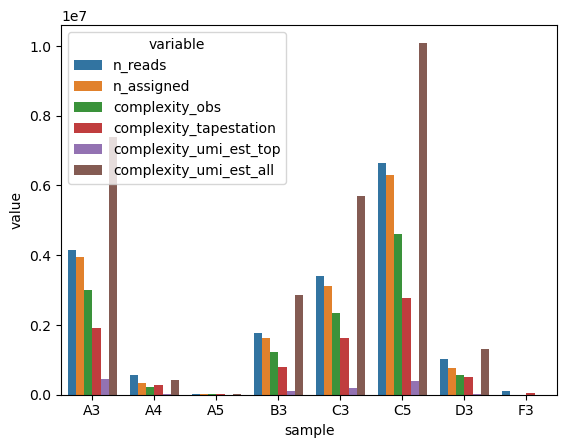

In [38]:
ax = sns.barplot(
    df_data[['sample', 'n_reads', 'n_assigned', 'complexity_obs', 'complexity_tapestation', 'complexity_umi_est_top', 'complexity_umi_est_all']] \
        .drop_duplicates() \
        .melt(id_vars='sample'),
    x='sample',
    y='value',
    hue='variable')

#### Estimated coverage and duplication rate

"Coverage" = proportion of physical molecules that were sequenced and assigned.
- Assume sampling `n_assigned` reads from `complexity_tapestation` molecules.

In [39]:
df_data[['sample', 'n_assigned', 'complexity_tapestation']].drop_duplicates() \
    .set_index('sample')\
    .apply(
        lambda s: 1 - scipy.stats.binom.pmf(0, n=s['n_assigned'], p=1/s['complexity_tapestation']),
        axis=1) \
    .rename('coverage')

sample
A3    0.873819
A4    0.710524
A5    0.587271
B3    0.870799
C3    0.852320
C5    0.896294
D3    0.780152
F3    0.000000
Name: coverage, dtype: float64

Duplication rate = proportion of sequenced and assigned reads that are duplicates

In [40]:
df_barcode_counts.groupby('sample')[['count_dedup', 'count']].sum().pipe(
    lambda df: df.assign(**{
        'duplication rate': (df['count'] - df['count_dedup'])/df['count_dedup']}))

count_dedup    count  duplication rate
sample                                        
A3          2992182  3837290          0.282439
A4           226362   326257          0.441306
A5            13803    22478          0.628487
B3          1210888  1573756          0.299671
C3          2356277  3041243          0.290698
C5          4599621  6139320          0.334745
D3           565064   737862          0.305803

In [41]:
df_data[['sample', 'n_assigned', 'complexity_tapestation']].drop_duplicates() \
    .set_index('sample')\
    .apply(
        lambda s:
            scipy.stats.binom.mean(n=s['n_assigned'], p=1/s['complexity_tapestation']) / \
            (1 - scipy.stats.binom.pmf(0, n=s['n_assigned'], p=1/s['complexity_tapestation'])),
        axis=1) \
    .map(lambda s: (s - 1) / s) \
    .rename('duplication rate')

/tmp/ipykernel_9421/2906528009.py:5: RuntimeWarning: invalid value encountered in double_scalars
  scipy.stats.binom.mean(n=s['n_assigned'], p=1/s['complexity_tapestation']) / \


sample
A3    0.577873
A4    0.426849
A5    0.336377
B3    0.574470
C3    0.554391
C5    0.604493
D3    0.484987
F3         NaN
Name: duplication rate, dtype: float64

# Ligation QC

| Round    | Tags used (wells) | Tags used (ID) | Tags added during pooling | Pooling orientation     |
| -------- | ----------------- | -------------- | ------------------------- | ----------------------- |
| R1       | A1-A11, B1-B11    | 1-11, 13-23    | A12 (12), B12 (24)        | 12 apart                |
| R2       | C1-C11, D1-D11    | 1-11, 13-23    | C12 (12), D12 (24)        | symmetric around C12/D1 |
| R3       | E1-E11, F1-F11    | 1-11, 13-23    | E12 (12), F12 (24)        | 12 apart                |

In [42]:
rounds_to_pooled_tags = {
    'R1': (12, 24),
    'R2': (12, 24),
    'R3': (12, 24)
}

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


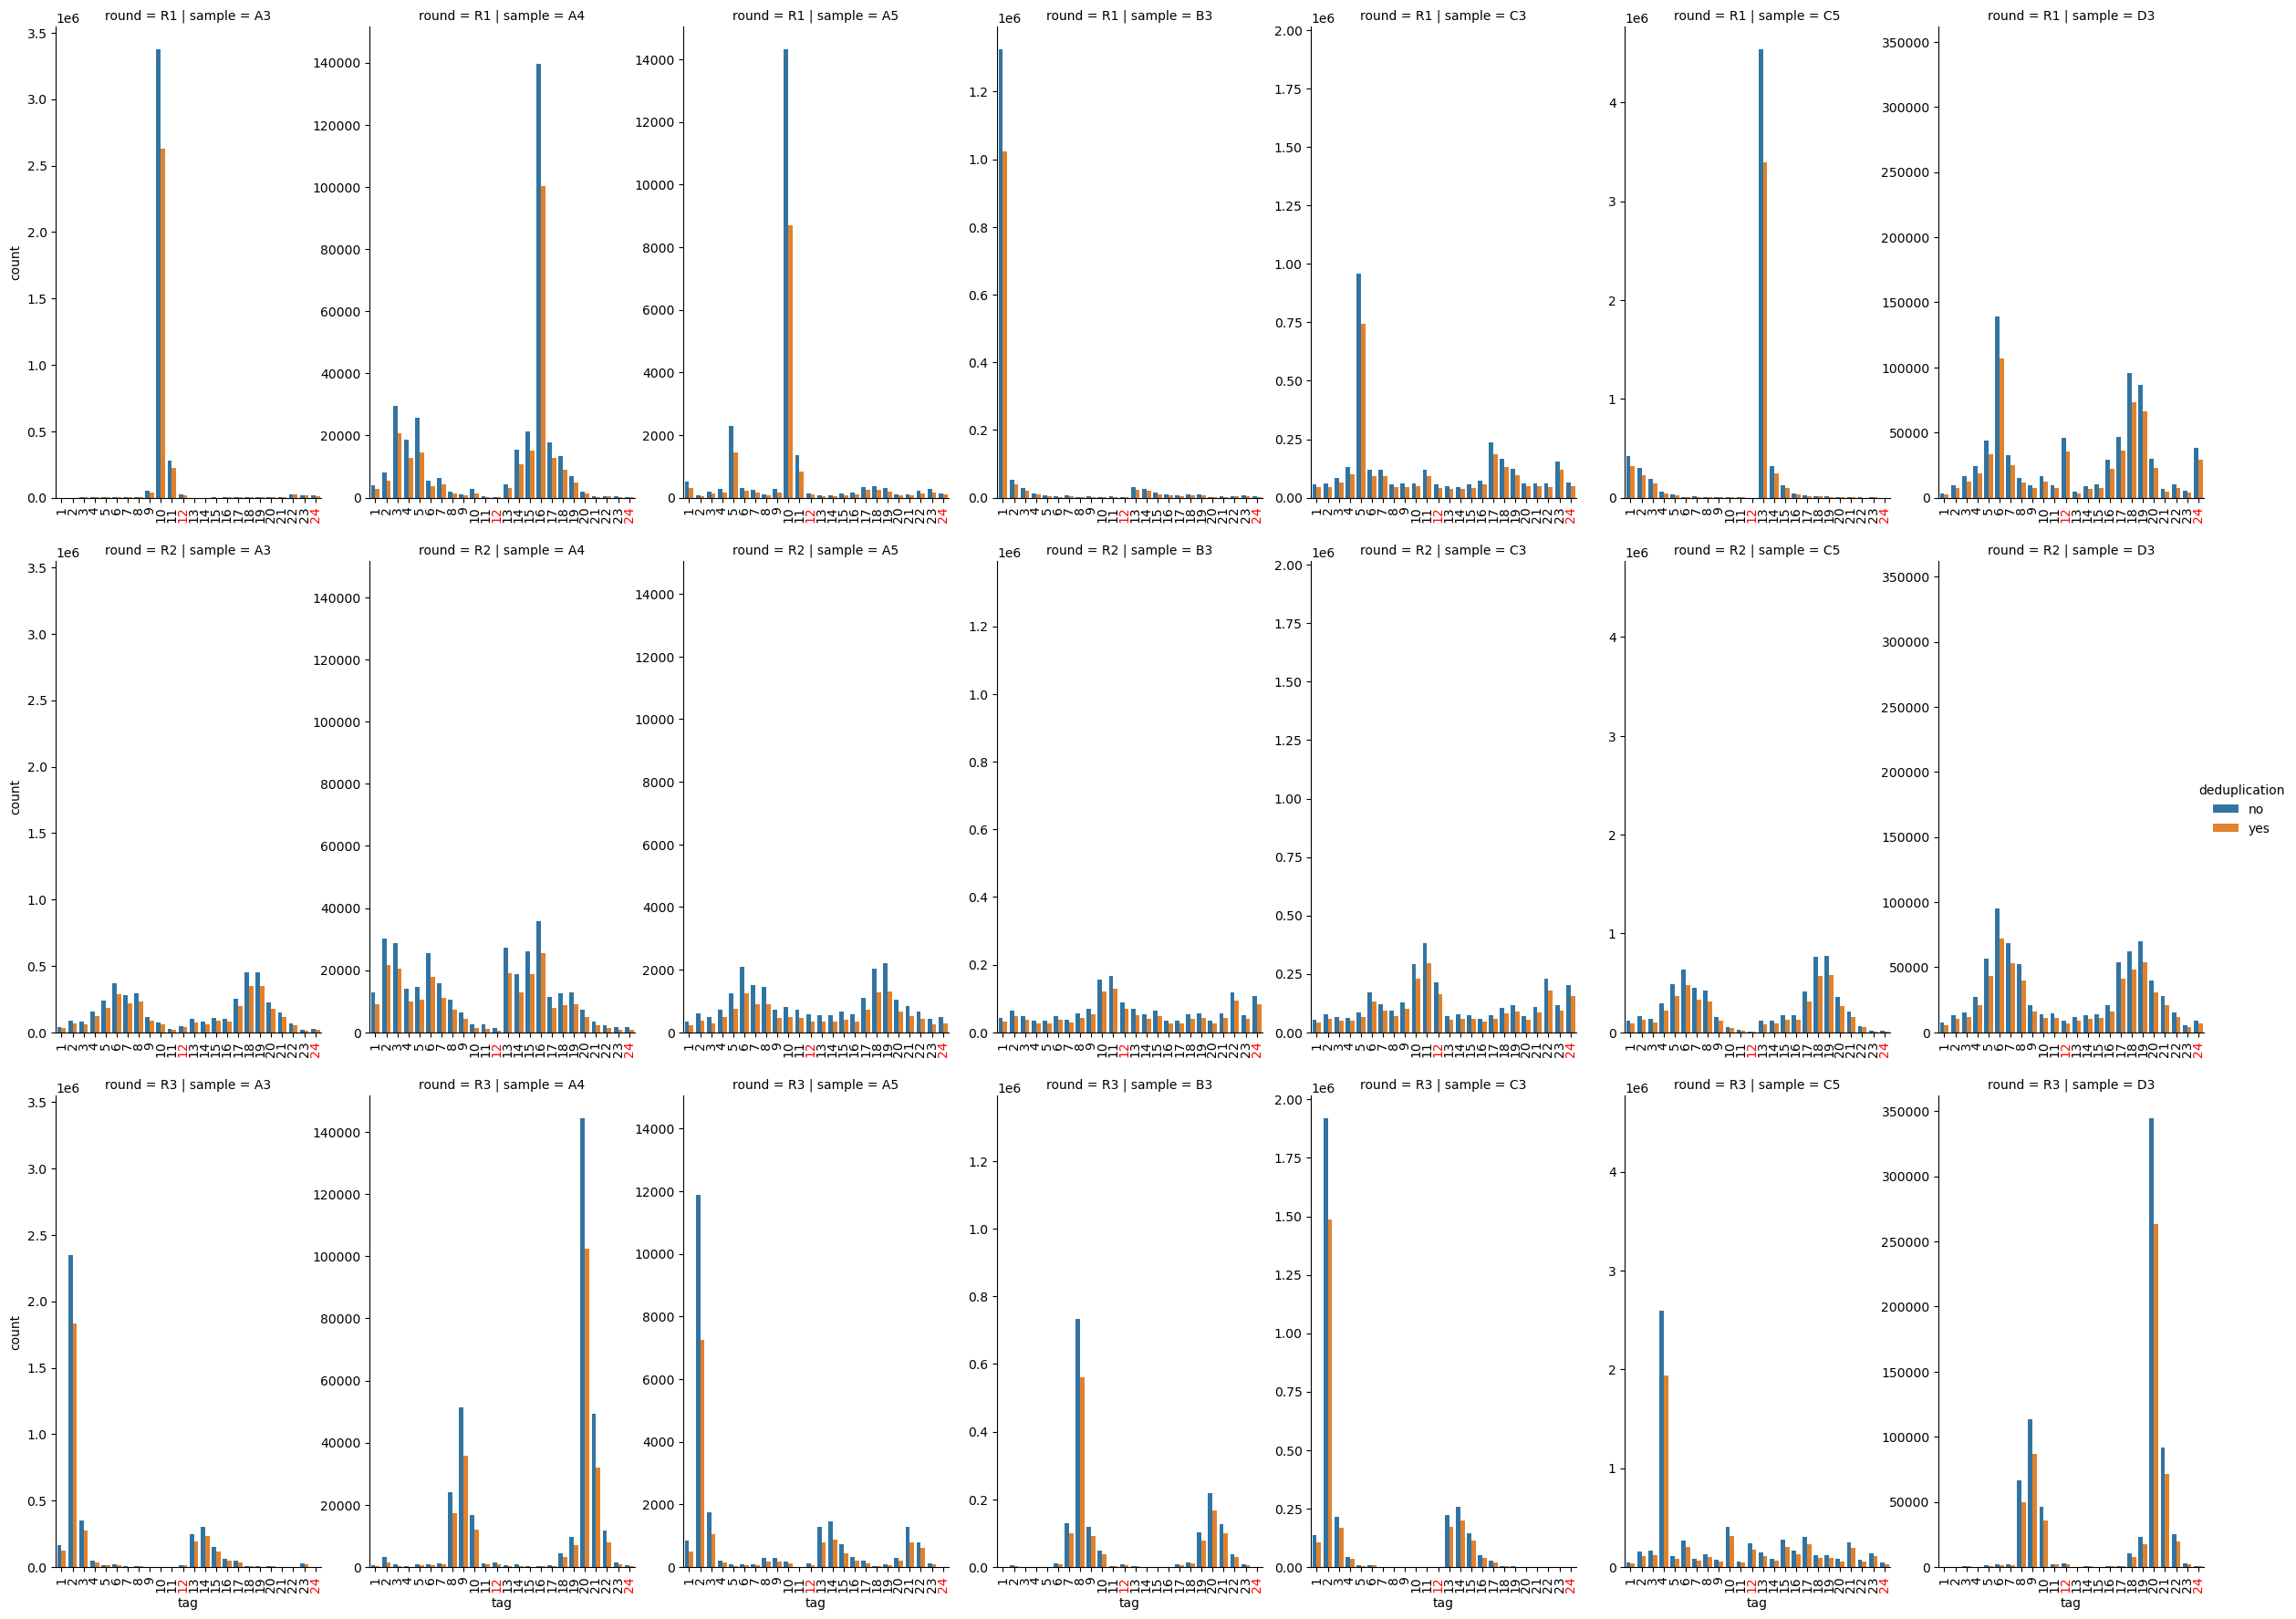

In [43]:
g = sns.catplot(
    df_tag_counts,
    kind='bar',
    x='tag',
    y='count',
    row='round',
    row_order=ROUNDS,
    hue='deduplication',
    col='sample',
    sharex=False,
    sharey='col')

# red color for xticklabels corresponding to tags added during pooling
for (r, sample), ax in g.axes_dict.items():
    for text in ax.get_xticklabels():
        if int(text.get_text()) in rounds_to_pooled_tags[r]:
            text.set_color('red')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

g.figure.set_size_inches(25, 18)

g.figure.savefig(
    os.path.join(DIR_RESULTS, 'tag_counts_by_sample.pdf'),
    bbox_inches='tight',
    dpi=300)

## Flow diagram

In [45]:
for sample in df_barcode_counts['sample'].unique():
    fig = go.Figure(go.Parcats(
        dimensions=[{'label': r, 'values': df_barcode_counts.loc[df_barcode_counts['sample'] == sample, r]} for r in ROUNDS],
        counts=df_barcode_counts.loc[df_barcode_counts['sample'] == sample, 'count_dedup']))
    fig.update_layout(
        title_text=f'Sample: {sample}',
        width=600,
        height=600,
        margin=dict(l=10, b=10, t=50, r=10)
    )
    fig.show()
    fig.write_image(os.path.join(DIR_RESULTS, f'parcats_{sample}.pdf'))

### Alternative APIs

Plotly Graph Objects API: Sankey
- Highly customizable

Plotly Express: Parallel Categories
- Takes un-aggregated data (`df_umi_counts`), so plotting is slow.

HoloViews: slow

## Ligation of pooled tags

1. (Distribution over samples) For a given round, what proportion of tags were pooled tags?
2. (Distribution over samples) For a given round, what proportion of tags were accounted by each pooled tag?
4. (Distribution over samples) For a given partial (2 out of 3 rounds) barcode, what proportion of the "missing" round is made up of pooled tags?

In [46]:
df_pooled_tags_counts = (
    df_tag_counts
    .groupby(["sample", "round", "deduplication"], group_keys=False)
    .apply(lambda group: (
        group
        .assign(total=group["count"].sum())
        .loc[group["tag"].isin(rounds_to_pooled_tags[group.iloc[0]["round"]])]))
    .pipe(lambda df: df.assign(proportion=df['count']/df['total']))
    .sort_values(['deduplication', 'round', 'sample', 'proportion'])
    .reset_index(drop=True)
)

In [47]:
# assert that the number of counts observed at each round is the same for all samples
assert df_pooled_tags_counts.groupby(['sample', 'deduplication'])['total'].agg(lambda x: len(np.unique(x)) == 1).all()

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



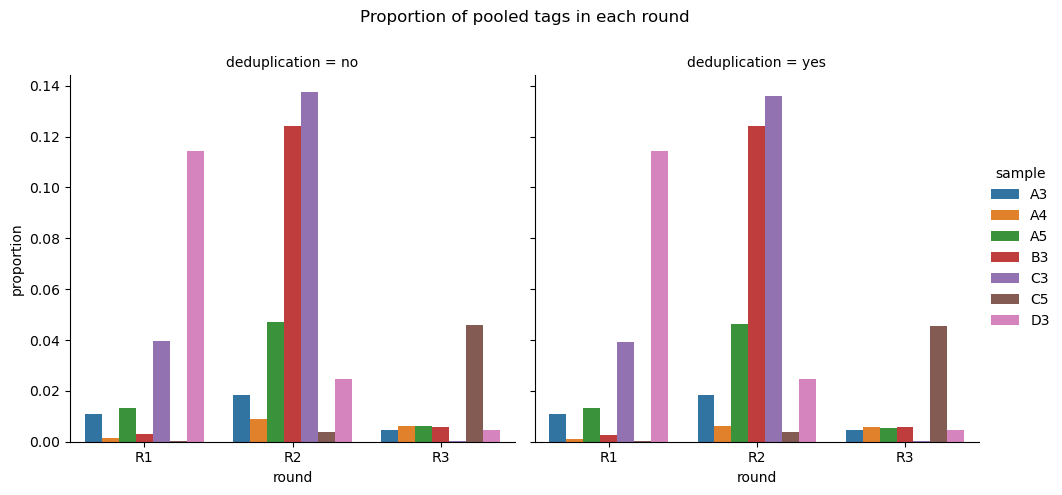

In [48]:
g = sns.catplot(
    df_pooled_tags_counts.groupby(['sample', 'round', 'deduplication'], as_index=False)['proportion'].sum(),
    kind='bar',
    x='round',
    y='proportion',
    hue='sample',
    col='deduplication')
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle('Proportion of pooled tags in each round')
g.figure.show()

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



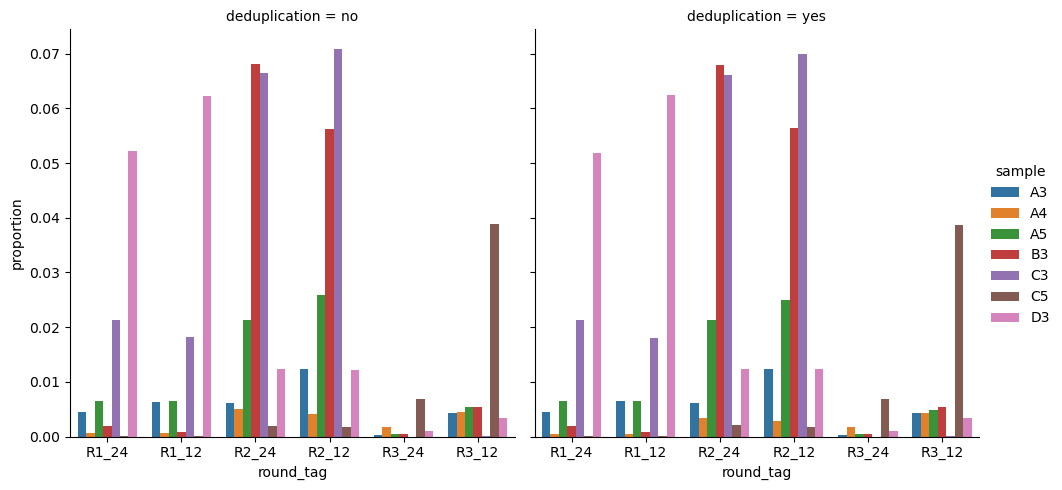

In [49]:
sns.catplot(
    df_pooled_tags_counts.assign(
        round_tag=df_pooled_tags_counts['round'].str.cat(df_pooled_tags_counts['tag'].astype(str), sep='_')),
    kind='bar',
    x='round_tag',
    y='proportion',
    hue='sample',
    col='deduplication')
g.figure.subplots_adjust(top=0.85)
g.figure.suptitle('Proportion of pooled tags in each round')
g.figure.show()

In [50]:
df_pooled_tag_proportion_per_partial_barcode = []
for i in range(len(ROUNDS)):
    partial_rounds = ROUNDS[:i] + ROUNDS[i+1:]
    pooled_round = ROUNDS[i]
    df_pooled_tag_proportion_per_partial_barcode.append((
        df_barcode_counts
        .groupby(['sample'] + partial_rounds, observed=True, as_index=False)
        .apply(lambda group:
               group.loc[group[pooled_round].isin(rounds_to_pooled_tags[pooled_round]), ['count', 'count_dedup']].sum(axis=0) / 
               group[['count', 'count_dedup']].sum(axis=0))
        .assign(**{pooled_round: -1, 'round': pooled_round})
        .rename(columns={'count': 'proportion', 'count_dedup': 'proportion_dedup'})
    ))
df_pooled_tag_proportion_per_partial_barcode = pd.concat(df_pooled_tag_proportion_per_partial_barcode) \
    .astype(dict(round='category'))

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



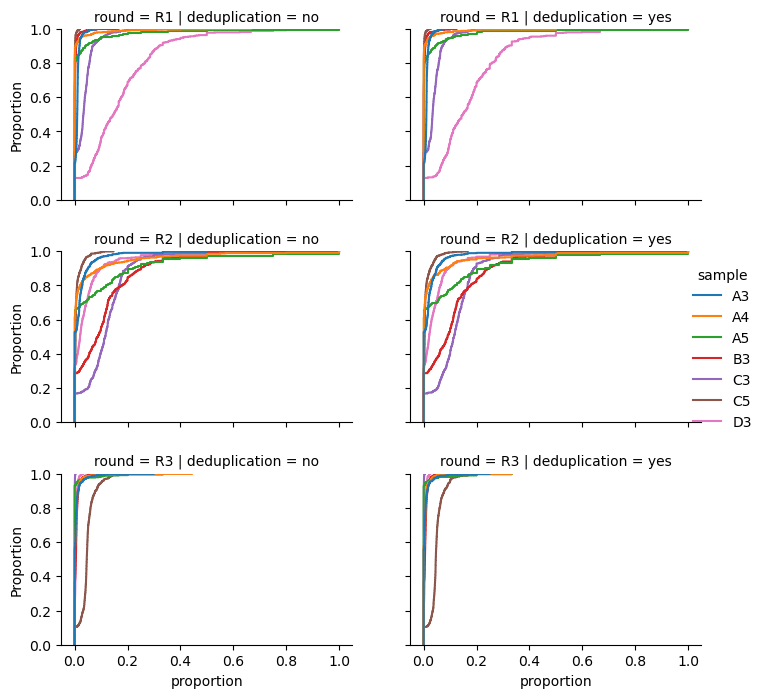

In [51]:
g = sns.displot(
    kind='ecdf',
    data=(
        df_pooled_tag_proportion_per_partial_barcode
        .rename(columns={'proportion': 'no', 'proportion_dedup': 'yes'}) \
        .melt(id_vars=['sample', 'round'],
              value_vars=['no', 'yes'],
              var_name='deduplication',
              value_name='proportion')),
    x='proportion',
    hue='sample',
    row='round',
    row_order=ROUNDS,
    col='deduplication',
    facet_kws={'gridspec_kws': dict(hspace=0.3)})
g.figure.set_size_inches((8, 8))

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



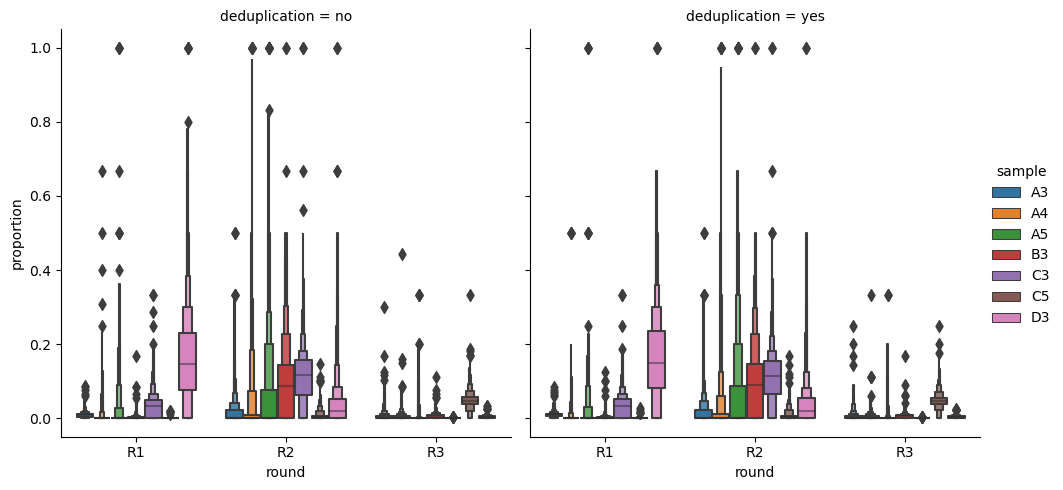

In [52]:
sns.catplot(
    kind='boxen',
    data=df_pooled_tag_proportion_per_partial_barcode \
        .rename(columns={'proportion': 'no', 'proportion_dedup': 'yes'}) \
        .melt(id_vars=['sample', 'round'],
              value_vars=['no', 'yes'],
              var_name='deduplication',
              value_name='proportion'),
    x='round',
    y='proportion',
    hue='sample',
    col='deduplication')

## Independence of each round

In [53]:
df_rounds_independence = []
for r1, r2 in itertools.combinations(ROUNDS, 2):
    for sample, group in df_barcode_counts.groupby('sample'):
        pvalue = scipy.stats.chi2_contingency((
            group
            .groupby([r1, r2], observed=True, as_index=False)['count'].sum()
            .pivot(columns=r2, index=r1)
            .fillna(0)
            .values
        )).pvalue
        df_rounds_independence.append(dict(sample=sample, r1=r1, r2=r2, pvalue=pvalue))
df_rounds_independence = pd.DataFrame(df_rounds_independence)

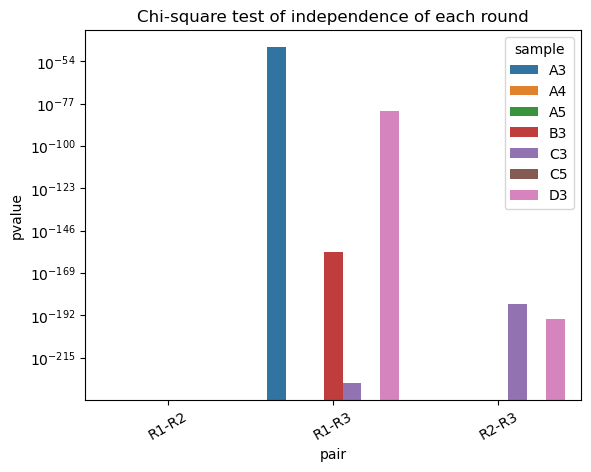

In [54]:
ax = sns.barplot(
    df_rounds_independence.assign(pair=df_rounds_independence['r1'].str.cat(df_rounds_independence['r2'], sep='-')),
    x='pair',
    y='pvalue',
    hue='sample')
ax.set_yscale('log')
ax.tick_params(axis='x', labelrotation=30)
ax.set_title('Chi-square test of independence of each round')
ax.figure.show()

# Analyze barcode count distributions

Structure of `dist_oligos` and `dist_unique_oligos` dictionaries
- key: sample
- value: pandas.Series of barcode counts

In [55]:
dist_oligos = {}
dist_unique_oligos = {}
for sample, sample_data in sample_barcode_counts.items():
    dist_oligos[sample] = pd.Series(sum(barcode_data.values()) for barcode_data in sample_data.values())
    dist_unique_oligos[sample] = pd.Series(map(len, sample_data.values()))

In [56]:
for sample, sample_data in sample_barcode_counts.items():
    print(f'Number of barcodes in sample {sample}:', len(sample_data))
    print('Frequency of most common barcodes:', dist_oligos[sample].sort_values(ascending=False).values[:10])
    print('Frequency of most common barcodes (dedup):', dist_unique_oligos[sample].sort_values(ascending=False).values[:10])
    print()

Number of barcodes in sample A3: 6461
Frequency of most common barcodes: [248083 246108 198089 157893 148737 134612 127727 120616  82623  80929]
Frequency of most common barcodes (dedup): [190360 189364 154756 123810 116692 105251 100553  93755  65582  63286]

Number of barcodes in sample A4: 6155
Frequency of most common barcodes: [7054 6282 6014 5927 5712 5375 3738 3579 3301 2931]
Frequency of most common barcodes (dedup): [5029 4524 4272 4207 4005 3884 2648 2593 2412 2092]

Number of barcodes in sample A5: 2381
Frequency of most common barcodes: [1058 1044  858  705  649  562  546  488  376  337]
Frequency of most common barcodes (dedup): [627 623 520 434 390 354 341 310 224 214]

Number of barcodes in sample B3: 7799
Frequency of most common barcodes: [67792 67314 49906 43323 36687 27299 25707 25516 24338 22961]
Frequency of most common barcodes (dedup): [52055 51065 39167 32817 28150 20552 20167 19349 18527 17360]

Number of barcodes in sample C3: 9645
Frequency of most common bar

In [57]:
df_dist_oligos = pd.concat(
    [
        s.rename("count")
        .to_frame()
        .pipe(
            lambda df: df.assign(
                **dict(sample=sample, proportion=df["count"] / df["count"].sum())
            )
            .sort_values("count", ascending=False)
            .assign(barcode_rank=range(1, len(df) + 1))
        )
        for sample, s in dist_oligos.items()
    ],
    axis=0,
).astype(dict(sample="category"))


df_dist_unique_oligos = pd.concat(
    [
        s.rename("count")
        .to_frame()
        .pipe(
            lambda df: df.assign(
                **dict(sample=sample, proportion=df["count"] / df["count"].sum())
            )
            .sort_values("count", ascending=False)
            .assign(barcode_rank=range(1, len(df) + 1))
        )
        for sample, s in dist_unique_oligos.items()
    ],
    axis=0,
).astype(dict(sample="category"))

### Count (or proportion of total count) per barcode (akin to scSPRITE Figure 1C)

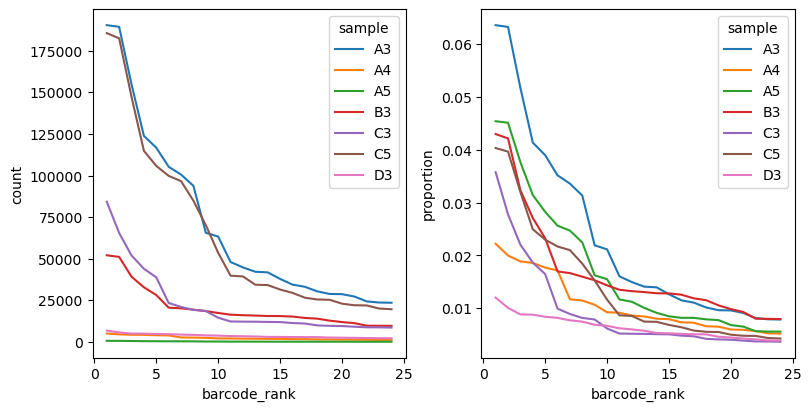

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True, sharex=True)
sns.lineplot(
    df_dist_unique_oligos.loc[df_dist_unique_oligos['barcode_rank'] < 25],
    x='barcode_rank',
    y='count',
    hue='sample',
    ax=axs[0])
sns.lineplot(
    df_dist_unique_oligos.loc[df_dist_unique_oligos['barcode_rank'] < 25],
    x='barcode_rank',
    y='proportion',
    hue='sample',
    ax=axs[1])
fig.savefig(
    os.path.join(DIR_RESULTS, 'barcode_count_by_barcode_rank.png'),
    dpi=300,
    bbox_inches='tight')